c:\Users\Admin\anaconda3\envs\stt_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training data size: 50
Test data size: 50
=== dataset sample ===
=== 인덱스i dataset ===
{'text': 'I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, 

c:\Users\Admin\anaconda3\envs\stt_env\lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Train loss: 0.5606
Training Accuracy: 100.00%
Test Accuracy: 100.00%

Epoch 2/3
Train loss: 0.1571
Training Accuracy: 100.00%
Test Accuracy: 100.00%

Epoch 3/3
Train loss: 0.0551
Training Accuracy: 100.00%
Test Accuracy: 100.00%
=== model result sample ===
input text: I love sci-fi and am willing to put up with a lot. Sci-fi movies/TV are usually underfunded, under-appreciated and misunderstood. I tried to like this, I really did, but it is to good TV sci-fi as Babylon 5 is to Star Trek (the original). Silly prosthetics, cheap cardboard sets, stilted dialogues, CG that doesn't match the background, and painfully one-dimensional characters cannot be overcome with a 'sci-fi' setting. (I'm sure there are those of you out there who think Babylon 5 is good sci-fi TV. It's not. It's clichéd and uninspiring.) While US viewers might like emotion and character development, sci-fi is a genre that does not take itself seriously (cf. Star Trek). It may treat important issues, yet not as a serious 

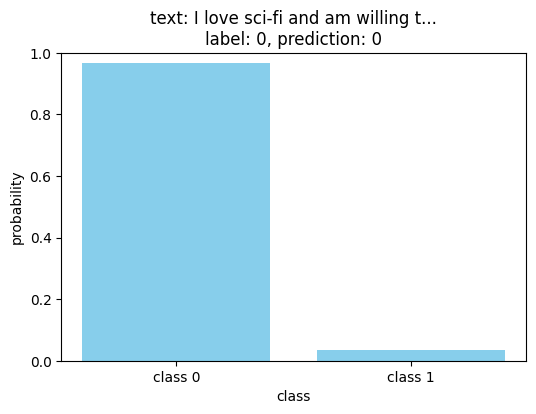

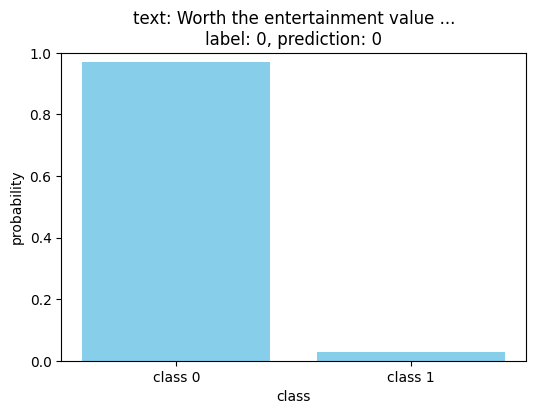

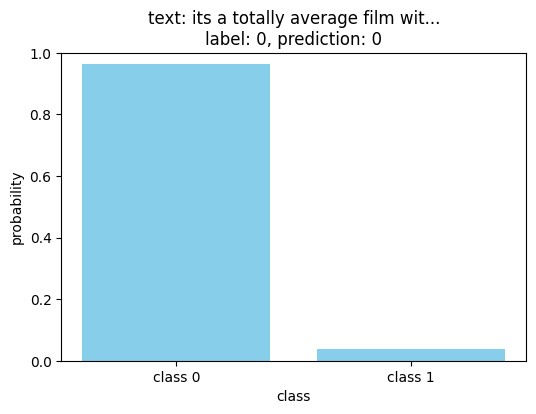

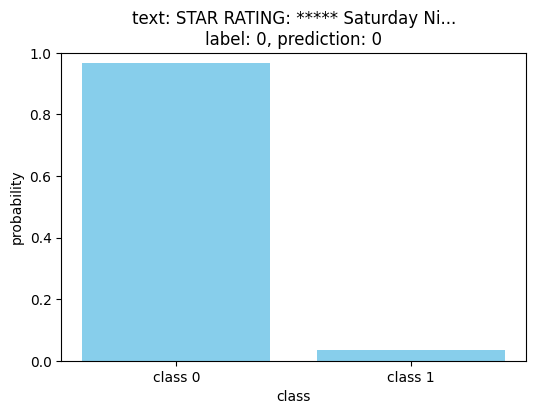

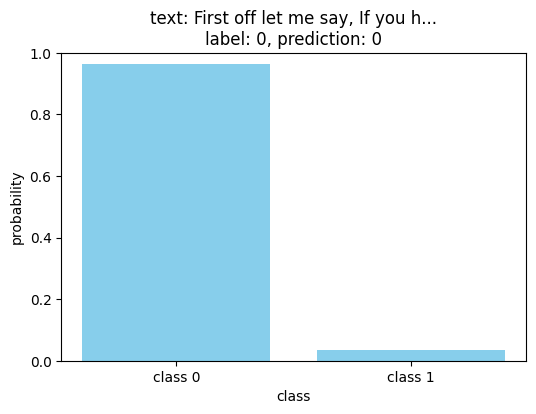

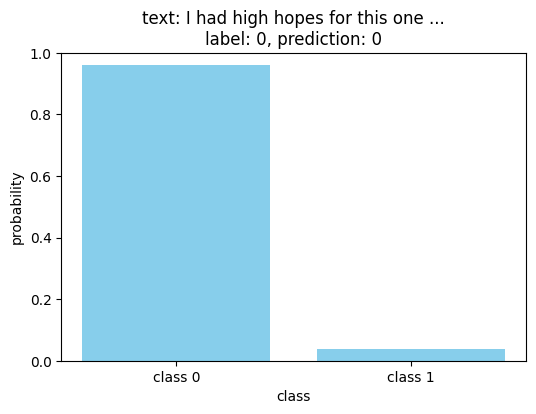

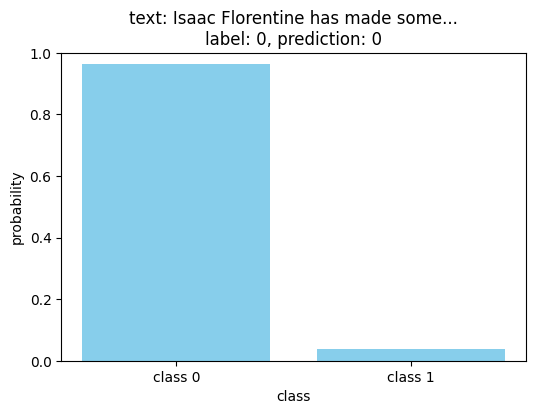

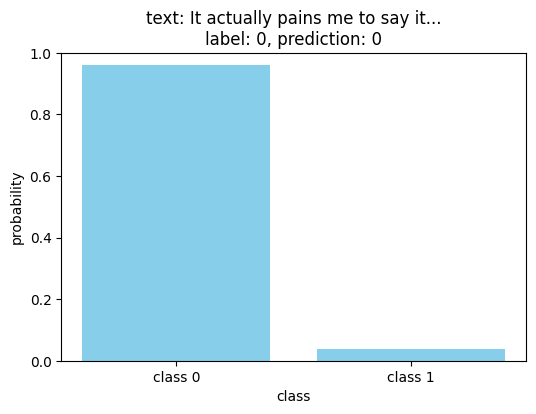

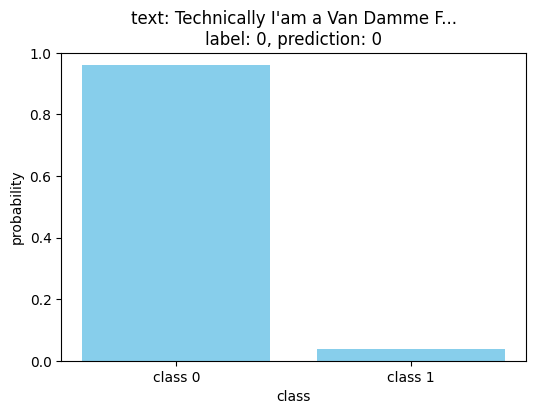

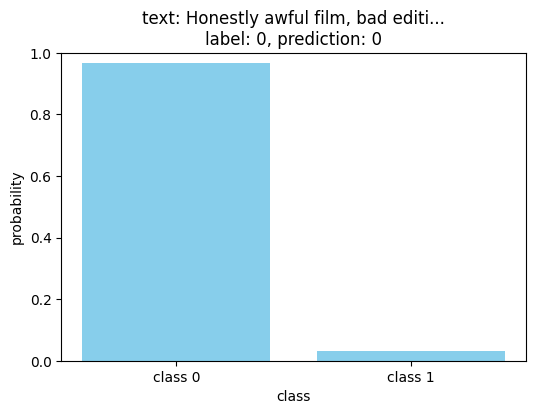

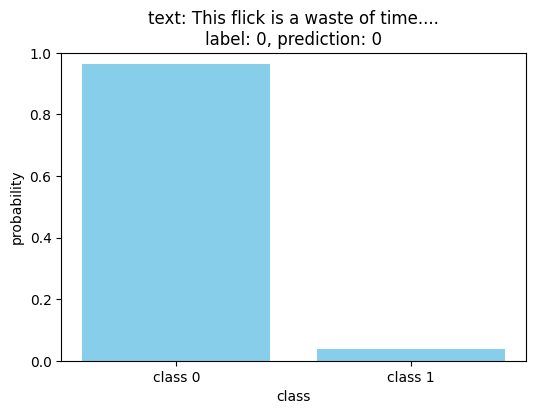

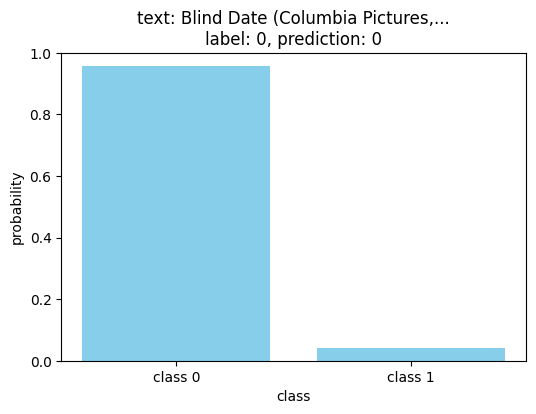

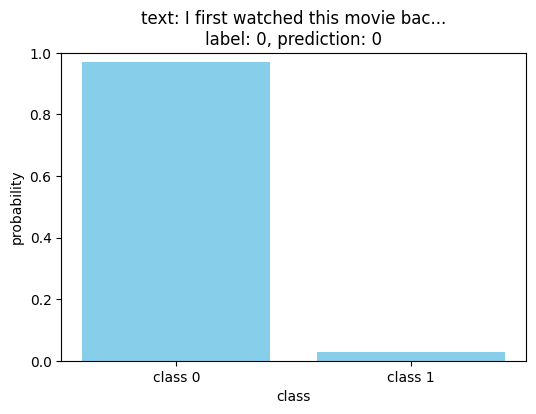

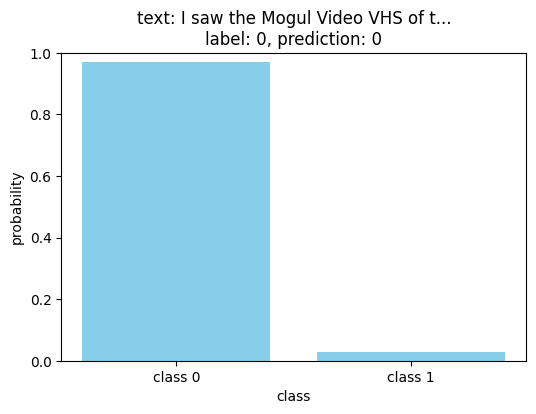

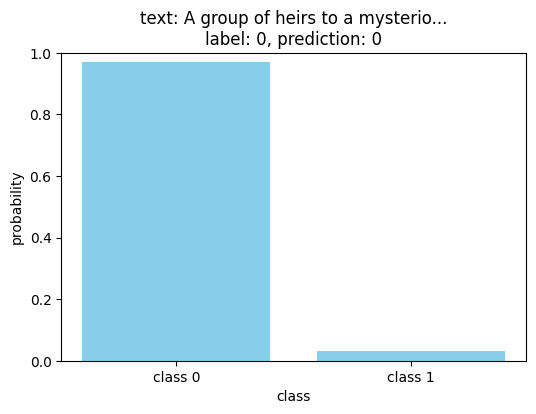

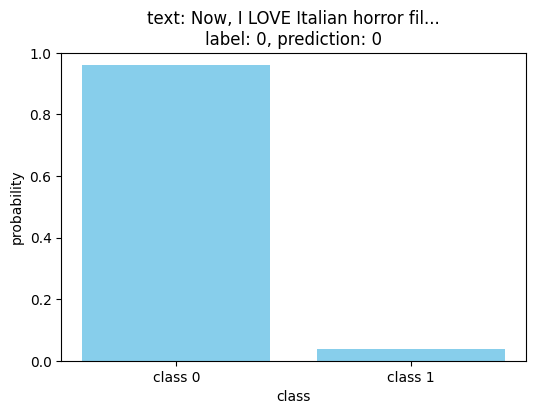

In [ ]:
# -*- coding: utf-8 -*-

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
import matplotlib.pyplot as plt
from datasets import load_dataset_builder
from datasets import load_dataset

"""
Hugging Face의 Transformers 라이브러리를 사용해 BERT 모델을 활용한 감정 분석을 수행
- `BertTokenizer: BERT 모델에 맞게 텍스트를 토큰화하는 도구
- `get_linear_schedule_with_warmup`: 학습률을 조절하는 스케줄러
- `AdamW`: Adam 옵티마이저의 변형으로 가중치 감쇠(weight decay)를 적용하는 옵티마이저
- `BertForSequenceClassification`: 감정 분석 등 분류 작업을 위한 BERT 모델
"""

# 1. 데이터셋 모듈: 텍스트와 레이블을 받아 BERT 입력 형식으로 변환합니다.
class SentimentDataset(Dataset):

    """
    *. __init__(): 데이터셋을 초기화 
    - texts: 입력 텍스트 리스트
    - labels: 각 텍스트에 해당하는 감정 레이블 (예: 긍정/부정)
    - tokenizer: 텍스트를 토큰화할 때 사용할 BERT 토크나이저
    - max_len: 토큰 시퀀스의 최대 길이를 지정

    *. __getitem__(): 주어진 인덱스(idx)에 해당하는 텍스트와 레이블을 가져와 BERT 입력 형식으로 변환
    encoding = tokenizer.encode_plus(
    : 텍스트를 토큰화하고 BERT가 요구하는는 입력 형식에 맞게 변환

    - add_special_tokens=True: [CLS]나 [SEP] 같은 특별 토큰 추가
    - max_length: 최대 길이를 지정하여 길이를 고정
    - padding='max_length': 길이가 부족할 경우 패딩을 추가
    - truncation=True: 너무 길면 자르기
    - return_attention_mask=True: 패딩 부분을 마스킹하는 어텐션 마스크 생성
    - return_tensors='pt': 결과를 PyTorch 텐서로 반환

    *. attention_mask가 필요한 이유
    - BERT 모델은 **입력 시퀀스의 길이를 고정(max_length)**해야 하기 때문에, 길이가 짧은 문장은 빈 공간을 [PAD] 토큰(=0)으로 채워야 함.
      하지만 모델이 패딩을 의미 없는 값으로 인식하고 무시해야 함 
      → 이를 위한 것이 attention_mask이다.

    *. return 
    딕셔너리 반환
    → 모델 학습에 필요한 입력 데이터(토큰 ID, 어텐션 마스크)와 원본 텍스트, 레이블을 딕셔너리 형태로 반환
    .flatten()은 텐서의 차원을 평평하게 만들어 1차원 배열로 만든다.
    """
    # 클래스 정의 및 초기화
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    # 데이터셋의 샘플 개수 반환
    def __len__(self):
        return len(self.texts)

    #  주어진 인덱스(idx)에 해당하는 텍스트와 레이블을 가져와 BERT 입력 형식으로 변환
    def __getitem__(self, idx):
        text = str(self.texts[idx])# self.texts[idx]가 str일 수도 있지만 혹시 모르니 str로 변환
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# 2. 학습 모듈: 에포크 단위로 모델 학습을 진행합니다.
def train_epoch(model, data_loader, optimizer, device, scheduler):

    """ 
    data_loader로부터 batch를 하나씩 가져와 모델을 학습
    bata_loader는 train_dataset을 DataLoader로 변환한 것

    batch에서 input_ids 열 추출하여 device로 이동
    attention_mask 열 추출하여 device로 이동
    labels 열 추출하여 device로 이동

    model에 input_ids, attention_mask, labels를 입력하고 출력을 받음
    출력으로부터 손실값을 계산하고 total_loss에 더함
    손실값으로 역전파 수행하여 가중치 업데이트
    스케줄러로 학습률 조절하며, 옵티마이저 초기화 
    옵티마이저 초기화하는 이유 : 각 배치마다 새로운 가중치로 업데이트하기 위해 그레디언트를 초기화함. 
    
    (중요 : 가중치를 초기화하는 것이 아니라 그레디언트를 초기화하는 것임 !!!)

    🔹 1. loss.backward()가 무엇을 하는가?
      loss.backward()
      PyTorch에서는 역전파(Backpropagation) 를 수행하면,
      모델의 각 파라미터(가중치)에 대한 그래디언트(gradient)가 누적됨.
      즉, loss.backward()를 호출하면 현재 배치(batch)에 대한 그래디언트가 계산되어 모델의 grad 속성에 저장됨.

    🔹 2. optimizer.step()는 무엇을 하는가?
      optimizer.step()은 현재 배치에서 계산된 그래디언트를 이용해 모델의 가중치를 업데이트

    🔹 3. optimizer.zero_grad()가 필요한 이유
      PyTorch의 기본 동작은 그래디언트(gradient)가 누적되는 것.
      즉, loss.backward()를 호출할 때마다 이전 배치의 그래디언트가 누적되어 점점 커짐.
      이를 방지하려면 매 배치마다 optimizer.zero_grad()를 호출하여 그래디언트를 초기화해야 함.

      배치를 여러 번 돌리는 이유는 가중치가 아니라 그래디언트(Gradient) 를 다루기 위해서.
      optimizer.zero_grad()는 가중치(Weights)를 초기화하는 것이 아니라, 그래디언트(Gradient)를 초기화하는 것.
      즉, 가중치는 계속해서 업데이트되며, 그래디언트는 매 배치마다 초기화되는 구조.
    """

    model.train()
    total_loss = 0

    for batch in data_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return total_loss / len(data_loader)

# 3. 평가 모듈: 모델의 정확도를 평가합니다.
def eval_model(model, data_loader, device):

    """ 
    모델을 평가하는 함수

    data_loader로부터 batch를 하나씩 가져와 모델을 평가
    batch에서 input_ids 열 추출하여 device로 이동
    batch에서 attention_mask 열 추출하여 device로 이동
    batch에서 labels 열 추출하여 device로 이동
    model에 input_ids, attention_mask을 입력하고 출력을 받음
    모델을 평가하기 위해 torch.no_grad()로 감싸서 그래디언트 계산을 비활성화
    모델의 출력에서 가장 큰 값의 인덱스를 예측값으로 사용 (모델의 출력은 로짓 값이며, 가장 큰 값의 인덱스가 예측값)

    logit 이란? 
    로짓은 Softmax 함수 적용 전의 출력값으로, 모델이 예측한 각 클래스의 점수(score) 를 의미.

    ✔ outputs.logits는 모델이 예측한 원시 점수(Softmax 적용 전)이며, 확률이 아님.
    ✔ torch.max(outputs.logits, dim=1)를 사용하면 가장 높은 점수를 가진 클래스를 예측값으로 변환 가능.
    ✔ 확률이 필요하다면 Softmax(다중 분류) 또는 Sigmoid(이진 분류)를 적용해야 함.

    즉, logits는 "모델의 최종 예측 점수"이며, 확률이 아닌 원시 값이므로 추가 변환이 필요할 수 있다다!

    예측값(logit이 가장 큰값의 )과 실제 레이블을 비교하여 정확한 예측 수를 계산

    output은 객체이기 때문에 .logit과 같은 기능을 사용할 수 있음

    리턴은 정확히 맞춘 예측 수를 전체 데이터 개수로 나눠 평균 정확도를 계산
    """
    model.eval()
    correct_predictions = 0
    total = 0

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs.logits, dim=1)
            correct_predictions += torch.sum(preds == labels)
            total += labels.size(0)

    return correct_predictions.double() / total

# 4. 데이터셋 샘플 시각화: 데이터셋의 샘플 구조를 출력합니다. 총 3개만 출력 
def visualize_dataset_sample(dataset, num_samples=3):
    """ 
    num_samples만큼 데이터셋 샘플을 출력
    dataset은 train_dataset이며, train_dataset은 SentimentDataset 클래스의 객체임.
    dataset의 i번째 샘플을 가져와 text, input_ids, attention_mask, labels 등을 출력
    """
    print("=== dataset sample ===")
    for i in range(num_samples):
        sample = dataset[i]
        print("=== 인덱스i dataset ===")
        print(sample)
        print(f"sample {i+1}:")
        print("text:", sample['text'])
        print("input token IDs:", sample['input_ids'])
        print("attention mask:", sample['attention_mask'])
        print("label:", sample['labels'])
        print("-----")

# 5. 모델 결과 시각화 (텍스트 출력): 입력 텍스트와 예측된 결과, 실제 레이블 및 로짓을 출력합니다.
def visualize_model_results(model, data_loader, device, num_samples=1):
    model.eval()
    print("=== model result sample ===")
    with torch.no_grad():
        for i, batch in enumerate(data_loader):
            if i >= num_samples:
                break
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs.logits, dim=1)
            for j in range(len(batch['text'])):
                print(f"input text: {batch['text'][j]}")
                print(f"prediction: {preds[j].item()}, label: {labels[j].item()}")
                print(f"logit: {outputs.logits[j].cpu().numpy()}")
                print("-----")

# 6. 모델 결과 시각화 (그래프): Matplotlib을 사용해 각 클래스의 확률을 막대그래프로 출력합니다.
def visualize_model_results_with_plot(model, data_loader, device, num_samples=1):
    model.eval()
    print("=== 모델 결과 시각화 (그래프) ===")
    with torch.no_grad():
        for i, batch in enumerate(data_loader):
            if i >= num_samples:
                break
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            for j in range(len(batch['text'])):
                probs = torch.softmax(outputs.logits[j], dim=0).cpu().numpy()
                classes = [f"class {k}" for k in range(len(probs))]
                plt.figure(figsize=(6,4))
                plt.bar(classes, probs, color='skyblue')
                plt.title(f"text: {batch['text'][j][:30]}...\nlabel: {labels[j].item()}, prediction: {torch.argmax(outputs.logits[j]).item()}")
                plt.xlabel("class")
                plt.ylabel("probability")
                plt.ylim(0, 1)
                plt.show()

def main():

    """ 
    * Hyperparameters 설정
    - PRE_TRAINED_MODEL_NAME: 사전 훈련된 BERT 모델 이름
    - MAX_LEN: 토큰 시퀀스의 최대 길이
    - BATCH_SIZE: 배치 크기
    - EPOCHS: 에포크 수
    - DEVICE: 사용할 디바이스 (GPU 또는 CPU)

    * 토크나이저와 모델 로드
    - tokenizer: tokenizer는 Hugging Face의 BertTokenizer 클래스 객체
    🔹 tokenizer 객체의 역할
        - 텍스트를 BERT 모델이 이해할 수 있는 형식(토큰 ID)로 변환
        - BERT가 요구하는 특수 토큰([CLS], [SEP]) 추가
        - 패딩(Padding) 및 시퀀스 길이 조정
        - 어텐션 마스크 생성 (패딩된 부분을 무시하도록 설정)
    즉, tokenizer는 텍스트를 BERT 모델이 이해할 수 있는 형식으로 변환하는 역할을 함. (문장을 숫자로 변환)

    - model: model은 Hugging Face의 BertForSequenceClassification 클래스 객체
    🔹 model 객체의 역할
        - BertModel을 기반으로 한 문장 분류 모델
        - 사전 학습된 BERT 모델의 마지막 레이어 위에 분류용 선형(Linear) 레이어 추가
        - 입력된 문장의 감정 분석(긍정/부정) 수행
    출력 : [1.23, -0.98]: 긍정(1.23), 부정(-0.98)의 로짓 값
    ㄴ torch.argmax(outputs.logits, dim=1)을 하면 최종 예측 결과를 얻을 수 있음.

    * IMDb 감정 분석 데이터셋 로드
    Hugging Face의 datasets 라이브러리를 사용해 IMDb 데이터셋을 로드


    accuracy_tensor.item()의 의미
    .item()을 호출하면 텐서를 Python의 숫자(float) 값으로 변환.
    ㄴ .item()을 사용하지 않으면 tensor(0.8923)처럼 출력됨.
    ㄴ .item()을 사용하면 0.8923이라는 순수한 Python float 값이 됨.


    """
    
    # ----------------------------------------------------------------------------
    # 하이퍼파라미터 설정
    PRE_TRAINED_MODEL_NAME = 'bert-base-uncased'
    MAX_LEN = 128
    BATCH_SIZE = 16
    EPOCHS = 3
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # ----------------------------------------------------------------------------
    # 토크나이저와 모델 로드
    tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)
    model = BertForSequenceClassification.from_pretrained(PRE_TRAINED_MODEL_NAME, num_labels=2)
    model = model.to(DEVICE)

    # ----------------------------------------------------------------------------
    # IMDb 감정 분석 데이터셋 로드 (훈련 + 테스트 분리)
    # 라이브러리를 쓰지 않고, HTTP API 요청을 통해 데이터셋을 다운로드 받을 수도 있음
    # 여기서는 라이브러리를 통해 데이터셋을 다운로드하도록 함
    print("Downloading IMDb dataset...")
    dataset = load_dataset("imdb") # Hugging Face의 datasets 라이브러리를 통해 API를 호출

    # 훈련 데이터 (25,000개 중 5000개만 사용)
    train_texts = dataset["train"]["text"][:50]
    train_labels = dataset["train"]["label"][:50]

    # 테스트 데이터 (25,000개 중 5000개만 사용)
    test_texts = dataset["test"]["text"][:50]
    test_labels = dataset["test"]["label"][:50]

    print(f"Training data size: {len(train_texts)}")
    print(f"Test data size: {len(test_texts)}")

    # 훈련 데이터셋 및 DataLoader 생성
    train_dataset = SentimentDataset(train_texts, train_labels, tokenizer, MAX_LEN)
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

    # 테스트 데이터셋 및 DataLoader 생성 (훈련과 별개로 유지)
    test_dataset = SentimentDataset(test_texts, test_labels, tokenizer, MAX_LEN)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    # --------------------------------------------------------------
    # 데이터셋 샘플 시각화 (훈련 데이터)
    visualize_dataset_sample(train_dataset, num_samples=3)

    #--------------------------------------------------------------
    # 옵티마이저 및 스케줄러 설정
    optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
    total_steps = len(train_loader) * EPOCHS
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

    # --------------------------------------------------------------
    # 에포크 단위로 모델 학습 및 평가
    for epoch in range(EPOCHS):
        print(f'\nEpoch {epoch+1}/{EPOCHS}')
        train_loss = train_epoch(model, train_loader, optimizer, DEVICE, scheduler)
        print(f'Train loss: {train_loss:.4f}')

        # 학습 데이터셋에서 정확도 평가 (과적합 여부 확인)
        train_accuracy = eval_model(model, train_loader, DEVICE)
        print(f'Training Accuracy: {train_accuracy.item()*100:.2f}%')

        # 테스트 데이터셋에서 정확도 평가 (실제 성능 확인)
        test_accuracy = eval_model(model, test_loader, DEVICE)
        print(f'Test Accuracy: {test_accuracy.item()*100:.2f}%')

    # --------------------------------------------------------------
    # 모델 결과 시각화 (테스트 데이터에서 샘플 확인)
    visualize_model_results(model, test_loader, DEVICE, num_samples=1)
    visualize_model_results_with_plot(model, test_loader, DEVICE, num_samples=1)

if __name__ == '__main__':
    main()
